# Bayesian Optimization using inferred model

Condider a problem where you have to perform optimization for decision making. You don't know about the world very much and thus you have to do bayesian inference to discover it.

This formulation covers a wide range of practical tasks, here are some of them:
 * Maximizing stochastic output of model $E_{p(\theta|D)}[f(X)] \rightarrow max X$
 * Minimizing costs of inputs to archive target $E_{p(y|X, \theta, D)}[L(y_{target}, X, y)] \rightarrow min X$
 * Minimizing Bayesian risk: $E_{p(y|X, \theta, D)}[L(y_p, y)] \rightarrow min y_p$


In [1]:
%matplotlib inline
import functools
import numpy as np
from theano import theano, tensor as tt
import matplotlib.pyplot as plt
import pymc3 as pm
np.random.seed(42)

## Quadratic problem
Consider a simple quadratic problem with unknown parameters. Here comes bayesian inference to get model with that we need for our opimization

In [2]:
def f(x, a, b, c):
    return a*x**2 + b*x + c

### True data
Generate true data

In [3]:
x_obs = np.random.uniform(-5, 5, size=(15,)).astype('float32')
a, b, c = 1, 2, 3
min_ = np.array([-b/2/a])
y_obs = f(x_obs, a, b, c) + np.random.normal(size=x_obs.shape).astype('float32')

### Final task
Our task is to find th minimum of the unknown function without evaluating it. That differs a bit with traditional bayesian optimization using Gaussian Process. Here optimization have to deal with uncertainty.

Now let's look at true optima

In [4]:
min_

array([-1.])

And at the data

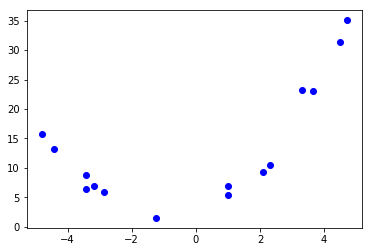

In [5]:
plt.plot(x_obs, y_obs, 'bo');

For inference you can use every method you like. Here I use SVGD just to show that it's result can be used in inferece as well as any other tool in variational module.

In [6]:
sgd = functools.partial(pm.sgd, learning_rate=.001) # simple problem - simple optimizer
with pm.Model() as model:
    abc = pm.Normal('abc', sd=1, shape=(3,))
    x = theano.shared(x_obs, 'x_obs')
    x2 = x**2
    o = tt.ones_like(x)
    X = tt.stack([x2, x, o]).T
    y = X.dot(abc)
    pm.Normal('y', mu=y, observed=y_obs)
    histogram = pm.fit(4000, method='svgd', obj_optimizer=sgd)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 4000/4000 [00:23<00:00, 170.28it/s]


As a result we have a `Histogram` instance.

In [7]:
histogram.histogram.get_value().mean(0)

array([ 1.0527544 ,  1.99613583,  1.92554891], dtype=float32)

It contains particles inferred with SVGD, shared variable has exactly 100 samples for 3 variables.

In [8]:
type(histogram.histogram), histogram.histogram.get_value().shape

(theano.tensor.sharedvar.TensorSharedVariable, (100, 3))

100 is a default value. If you do not want use defaults, you can use the following code. For many particles evaluation can take significant part. For svgd we have a problem that we cannot know the moment when convergence is archived. May be in future there will be a callback to check convergence

In [9]:
with model:
    svgd = pm.SVGD(n_particles=500, jitter=.1)
    histogram = svgd.fit(1000, obj_optimizer=sgd)

100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s]


# Inference results

We don't have exact function as our observations were noisy

In [10]:
svgd.approx.histogram.get_value().mean(0)

array([ 1.10244656,  1.96198523,  1.12952435], dtype=float32)

In [11]:
histogram.apply_replacements(y, deterministic=True).eval()

array([  0.40329027,  32.367939  ,  11.61470795,   4.13825464,
         7.42515516,   7.42651224,  13.98887253,  23.09599495,
         4.24055386,   9.98482895,  17.06200409,  34.69278336,
        19.83602905,   4.60826921,   6.04763126], dtype=float32)

# Picture
Let's look at what we got from inference. There will be mean function.

In [12]:
from itertools import zip_longest

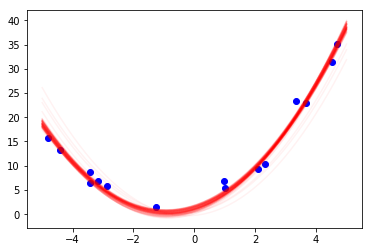

In [13]:
x.set_value(np.linspace(-5, 5, dtype='float32'))
plt.plot(x_obs, y_obs, 'bo');
y_dist = histogram.sample_node(y).eval()
for line in y_dist:
    plt.plot(np.linspace(-5, 5), line, 'r-', alpha=.05);

We need an optima for real function but we know only we distribution over possible functions. To find the minima we can get the minimum of expected function. It can be done out of the box with PyMC3 tools.

At first we must create someting we wrt want to minimize and what to minimize. In our problem it is `x` coordinate. 

# Optimization

In [33]:
# wrt what to minimize
# set x far from optima
x_ = theano.shared(pm.floatX(10.), 'x')
# and what to minimize
# Notice that we use random variable in out loss so it bocomes stochastic
y_ = abc[0]*x_**2  + abc[1]*x_ + abc[2]

In [34]:
N = 2000
hist_x = np.empty(N)
def cb(approx, current_loss, i):
    hist_x[i] = x_.get_value()

In [35]:
sgd = functools.partial(pm.sgd, learning_rate=.001)
opt = pm.Optimizer(histogram, y_, [x_], optimizer=sgd)
opt.fit(N, callbacks=[cb])

E_q[Loss] = 0.2091: 100%|██████████| 2000/2000 [00:00<00:00, 21663.11it/s]


# Optimization results
It's all right!

In [36]:
x_.get_value(), min_

(array(-0.7567644119262695, dtype=float32), array([-1.]))

# Loss history

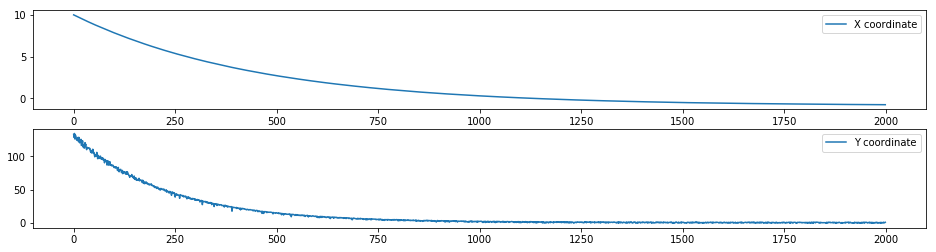

In [38]:
cmap = plt.get_cmap('cool')
fig, ax = plt.subplots(2, 1, figsize=(16, 4))
ax[0].plot(hist_x, label='X coordinate');
ax[1].plot(opt.hist, label='Y coordinate');
ax[0].legend();
ax[1].legend();